<p align="center">
  <img src="data/TITANIC COVER.png" width="1200" height="500">
</p>

# Titanic Survival Prediction

# 1. Introduction

* Brief overview of the Titanic survival competition at Kaggle.  
* Purpose of studying this dataset and objective of this notebook, audiences
* Methodology followed.  
* Key findings and observations.  
* Challenges, areas for potential improvements.

**Dataset**  
[Kaggle Competition and dataset link](https://www.kaggle.com/c/titanic)

**Contact**  
Reachme for more or discussion from [Linkedin](https://www.linkedin.com/in/fatih-calik-469961237/), [Github](https://github.com/fatih-ml) or [Kaggle](https://www.kaggle.com/fatihkgg)

# 2. Initial Data Exploration

## Importing the dependencies

In [183]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import pickle
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [184]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier 
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [185]:
df_train2 = pd.read_csv('data/train.csv')
df_test2 = pd.read_csv('data/test.csv')
df_train2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Prepare Datasets & First Observations

In [186]:
print(df_train2.shape)
print(df_test2.shape)

(891, 12)
(418, 11)


In [187]:
df = pd.concat([df_train2, df_test2], axis=0)

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [189]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns
numerical_features = df.select_dtypes(include='number').columns

In [190]:
df[categorical_features].describe().T

,count,unique,top,freq
Name,1309,1307,"Connolly, Miss. Kate",2
Sex,1309,2,male,843
Ticket,1309,929,CA. 2343,11
Cabin,295,186,C23 C25 C27,6
Embarked,1307,3,S,914


In [191]:
df[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,1309.0,655.000000,378.020061,1.00,328.0000,655.0000,982.000,1309.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.000,1.0000
Pclass,1309.0,2.294882,0.837836,1.00,2.0000,3.0000,3.000,3.0000
Age,1046.0,29.881138,14.413493,0.17,21.0000,28.0000,39.000,80.0000
SibSp,1309.0,0.498854,1.041658,0.00,0.0000,0.0000,1.000,8.0000
Parch,1309.0,0.385027,0.865560,0.00,0.0000,0.0000,0.000,9.0000
Fare,1308.0,33.295479,51.758668,0.00,7.8958,14.4542,31.275,512.3292


## Missing Values

In [192]:
df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# 3. Data Preprocessing

In [193]:
# we can easily decide to drop PassengerId, since it doesnt add value to our model
df.drop(columns=['PassengerId'], inplace=True)

In [194]:
# fill Embarked with the most requent observation
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

In [195]:
df.groupby('Pclass')['Fare'].median()

Pclass
1    60.0000
2    15.0458
3     8.0500
Name: Fare, dtype: float64

In [196]:
df['Fare'].fillna(8.0, inplace=True)

## Names

__Name feature is of course too varying. We can extract the titles from here, we will use it to fill nan values in age variable, also some Special Titles may have high survival rates. Also, surnames can be extracted here to build a connection with other family members__  

__I run the models only with my new 'title column' and the results was shockingly good an average of 0.79 Accuracy without hyperparamtre tuning, While the age alone is around 0.63, fares 0.68__

In [197]:
title_mapping = {
    'Mr.': 'Mr.',
    'Mrs.': 'Mrs.',
    'Miss.': 'Miss',
    'Ms.': 'Miss',
    'Master.': 'Master.',
    'Mlle.': 'Miss',
    'Mme.': 'Miss',
    'Dr.': 'Special_title',
    'Sir': 'Special_title',
    'Col.': 'Special_title',
    'Capt.': 'Special_title',
    'Don.': 'Special_title',
    'Major.': 'Special_title',
    'Jonkheer.': 'Special_title',
    'Rev.': 'Special_title',
    'Countess.': 'Special_title',
    'Lady.': 'Special_title',
}

In [198]:
# Extract title from name
df['Title'] = df['Name'].apply(lambda name: next((title_mapping[title] for title in title_mapping if title in name), None))

# Drop Name
df.drop(columns= ['Name'], inplace=True)

# Print the value counts
df['Title'].value_counts()

Mr.              757
Miss             265
Mrs.             197
Master.           61
Special_title     28
Name: Title, dtype: int64

## Age

In [199]:
# Fill Nan valuess according to their Titles, which also represents their age group in a degree
median_age_titles = df.groupby('Title')['Age'].transform('median').round(0)

# Fill missing Age values with the calculated medians
df['Age'] = df['Age'].fillna(median_age_titles)

__I want to apply discretization to age feature. Lets try to decide by inspiring from kdeplots and general age categories from domain__

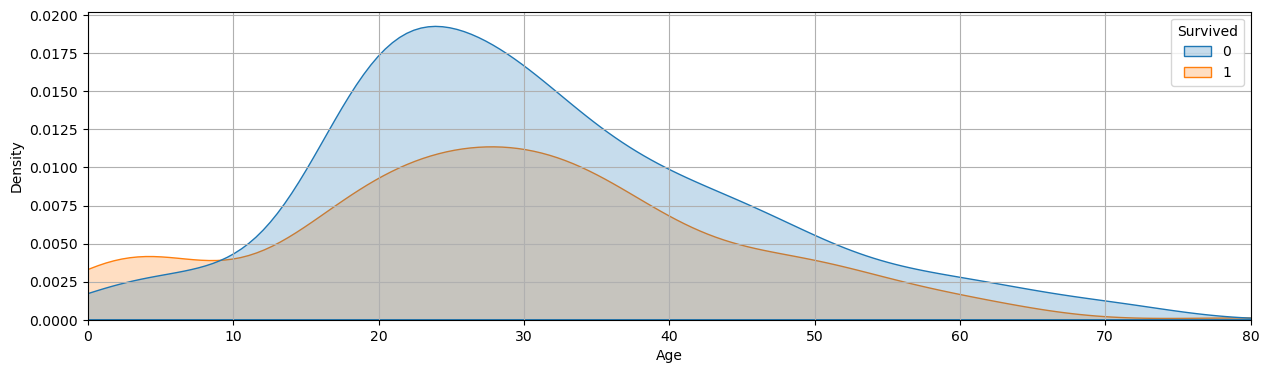

In [200]:
fig = plt.figure(figsize=(15,4))
sns.kdeplot(data=df_train2, x='Age', hue='Survived', common_norm=True, fill=True )
plt.xlim(0, 80)
plt.grid()
plt.show()

In [201]:
age_bins = [0, 12, 20, 30, 40, 50, 100]  
age_labels = ['Child', 'Teen', 'Young_Adult', 'Middle_Age', 'Senior_Adult', 'Old']

# Create the 'Age_Category' column using pd.cut
df['Age_Category'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Drop Age column
df.drop(columns=['Age'], inplace=True)

In [202]:
# Before data splitting test-train it is good to have numeric age as well
age_cat_order = ['Child', 'Teen', 'Young_Adult', 'Middle_Age', 'Senior_Adult', 'Old']
age_label_encoder = LabelEncoder()
age_label_encoder.classes_ = age_cat_order
df['Age_Cat_Label'] = age_label_encoder.transform(df['Age_Category'])
df.Age_Cat_Label.value_counts()

2    571
3    259
4    136
1    134
5    110
0     99
Name: Age_Cat_Label, dtype: int64

**I runned the model with only age feature alone, binned and label encoded with bins, the performance is better in almost all models**

## Cabin No

<p align="center">
  <img src="data/titanic_plan.png" width="300" height="300">
</p>

We will try to extract first letters from Cabin No as Decks:
[click for detailed plan](data/titanic_plan.png)   ( [image source](https://www.scmp.com/infographics/article/1633333/infographic-titanic) )

In [203]:
df['Cabin'].fillna('No_Cabin', inplace=True)

In [204]:
# Fill missing values, by No_cabin value
def extract_cabins(cabin):
    if cabin == 'No_Cabin':
        deck = 'No_Cabin'
    else:    
        deck = cabin[0]
    return deck

df['Deck'] = df['Cabin'].apply(extract_cabins)

In [205]:
df['Deck'].value_counts()

No_Cabin    1014
C             94
B             65
D             46
E             41
A             22
F             21
G              5
T              1
Name: Deck, dtype: int64

In [206]:
median_prices_deck_class = pd.DataFrame(df.groupby(['Pclass', 'Deck'])['Fare'].count())
median_prices_deck_class

Fare
Pclass Deck          
1      A           22
       B           65
       C           94
       D           40
       E           34
       No_Cabin    67
       T            1
2      D            6
       E            4
       F           13
       No_Cabin   254
3      E            3
       F            8
       G            5
       No_Cabin   693

**It will be very misleading to continue those no cabin values according to other values such as Pclass and Fare**
**There is a very big number to be filled, altough we have the plan, it is not giving a full picture but just an estimation**
**Moreover it will be turning into a Pclass, so better to remove now**

In [207]:
df.drop(columns=['Cabin', 'Deck'], inplace=True)

## Family

In [208]:
df['Family'] = df['Parch'] + df['SibSp'] + 1

In [209]:
df.drop(columns=['Parch', 'SibSp'], inplace=True)

## Ticket

Currently i will drop Ticket Column, since it will not add too much value to my model, however, it can be studied further, to make an connection with family members with duplicate ticket numbers

In [210]:
df.drop(columns=['Ticket'], inplace=True)

## Check for Outliers

In [211]:
df.sample(3)

,Survived,Pclass,Sex,Fare,Embarked,Title,Age_Category,Age_Cat_Label,Family
501,0.0,3,female,7.7500,Q,Miss,Young_Adult,2,1
164,0.0,3,male,39.6875,S,Master.,Child,0,6
373,NaN,2,male,13.0000,S,Mr.,Senior_Adult,4,1


In [212]:
df['Family'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family, dtype: int64

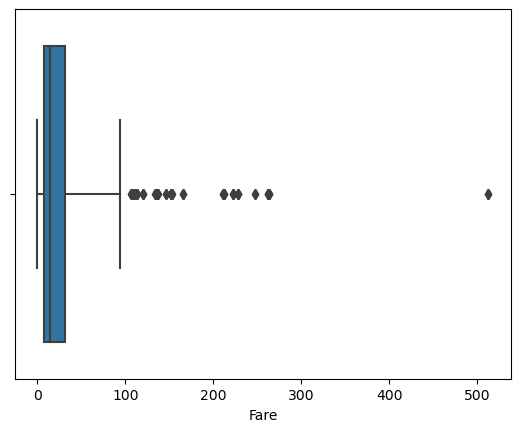

In [213]:
sns.boxplot(df['Fare'], whis=3);

In [214]:
#There are some outliers, lets try to observe them because i dont want to drop any observation unless neccessary
df[df['Fare']>250]

,Survived,Pclass,Sex,Fare,Embarked,Title,Age_Category,Age_Cat_Label,Family
27,0.0,1,male,263.0000,S,Mr.,Teen,1,6
88,1.0,1,female,263.0000,S,Miss,Young_Adult,2,6
258,1.0,1,female,512.3292,C,Miss,Middle_Age,3,1
311,1.0,1,female,262.3750,C,Miss,Teen,1,5
341,1.0,1,female,263.0000,S,Miss,Young_Adult,2,6
438,0.0,1,male,263.0000,S,Mr.,Old,5,6
679,1.0,1,male,512.3292,C,Mr.,Middle_Age,3,2
737,1.0,1,male,512.3292,C,Mr.,Middle_Age,3,1
742,1.0,1,female,262.3750,C,Miss,Young_Adult,2,5
24,NaN,1,female,262.3750,C,Mrs.,Senior_Adult,4,5


In [215]:
# and there are some 0 in tickets

print(len(df[df['Fare']<1]), ' Passengers have 0 ticket fare' '\n')
df[df['Fare']<1]

17  Passengers have 0 ticket fare



,Survived,Pclass,Sex,Fare,Embarked,Title,Age_Category,Age_Cat_Label,Family
179,0.0,3,male,0.0,S,Mr.,Middle_Age,3,1
263,0.0,1,male,0.0,S,Mr.,Senior_Adult,4,1
271,1.0,3,male,0.0,S,Mr.,Young_Adult,2,1
277,0.0,2,male,0.0,S,Mr.,Young_Adult,2,1
302,0.0,3,male,0.0,S,Mr.,Teen,1,1
413,0.0,2,male,0.0,S,Mr.,Young_Adult,2,1
466,0.0,2,male,0.0,S,Mr.,Young_Adult,2,1
481,0.0,2,male,0.0,S,Mr.,Young_Adult,2,1
597,0.0,3,male,0.0,S,Mr.,Senior_Adult,4,1
633,0.0,1,male,0.0,S,Mr.,Young_Adult,2,1


In [216]:
# As its seen 4 observations paid much higher than nearest max ticket prices for similar rooms.
# So i will change these ticket prices just around %10 higher than the closes max ticket price=280.0
df.loc[df['Fare'] > 300, 'Fare'] = 280.0

In [217]:
# Also there are 17 zero ticket prices - I will assign them to the minimum ticket prices of each class
min_tick_price_pclass = df[df['Fare']>5].groupby('Pclass')['Fare'].min()
min_tick_price_pclass

Pclass
1    25.5875
2     9.6875
3     6.2375
Name: Fare, dtype: float64

In [218]:
for i in [1, 2, 3]:
    condition = (df['Pclass'] == i) & (df['Fare'] == 0)
    df.loc[condition, 'Fare'] = min_tick_price_pclass[i]

In [219]:
# Fine all of them cleaned
df[  (df['Fare']<1) |  (df['Fare']>300) ]

,Survived,Pclass,Sex,Fare,Embarked,Title,Age_Category,Age_Cat_Label,Family


In [220]:
df.sample(3)

,Survived,Pclass,Sex,Fare,Embarked,Title,Age_Category,Age_Cat_Label,Family
874,1.0,2,female,24.0,C,Mrs.,Young_Adult,2,2
288,1.0,2,male,13.0,S,Mr.,Senior_Adult,4,1
378,NaN,1,male,50.0,S,Mr.,Old,5,1


## Data splitting

**Since we almost finished preprocessing, now we can divide the data again, and continue for more insights with EDA and visualizations**

In [221]:
idx_split = len(df_train2)
print(f"The last INCLUDED index of df_train will be {idx_split-1}")

df_train = df.iloc[:idx_split]
df_test = df.iloc[idx_split:].drop(columns=['Survived'])

The last INCLUDED index of df_train will be 890


In [222]:
df_train.tail(2)

,Survived,Pclass,Sex,Fare,Embarked,Title,Age_Category,Age_Cat_Label,Family
889,1.0,1,male,30.00,C,Mr.,Young_Adult,2,1
890,0.0,3,male,7.75,Q,Mr.,Middle_Age,3,1


In [223]:
df_test.head(2)

,Pclass,Sex,Fare,Embarked,Title,Age_Category,Age_Cat_Label,Family
0,3,male,7.8292,Q,Mr.,Middle_Age,3,1
1,3,female,7.0000,S,Mrs.,Senior_Adult,4,2


In [224]:
# Lets check whether the observations are correct
print(f"Train datasets are equal length = {len(df_train2) == len(df_train)}")
print(f"Test datasets are equal length = {len(df_test2) == len(df_test)}")

Train datasets are equal length = True
Test datasets are equal length = True


# 4. Exploratory data analysis and visualizations

In [225]:
categorical_features = df_train.select_dtypes(include=['object', 'category']).columns
numerical_features = df_train.select_dtypes(include='number').columns

## Frequencies & Distributions

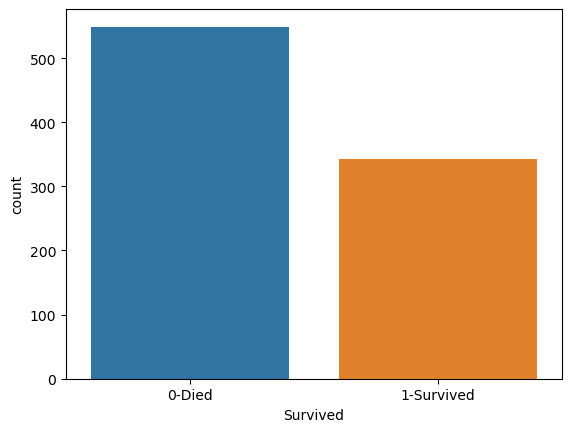

In [226]:
survived_map = {0: '0-Died', 1: '1-Survived'}
sns.countplot(df_train['Survived'].map(survived_map));

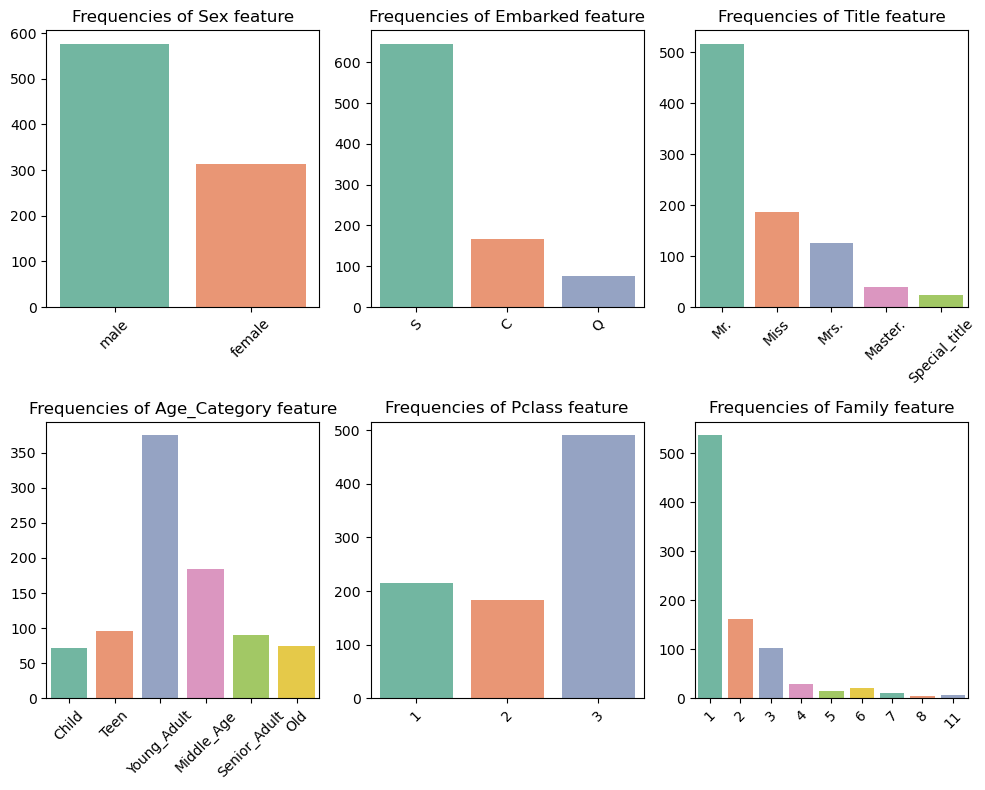

In [227]:
countplot_columns = list(categorical_features)
countplot_columns.extend(['Pclass', 'Family'])

colors = sns.color_palette('Set2', len(countplot_columns))
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    col = countplot_columns[i]
    val_cnt = df_train[col].value_counts()
    sns.barplot(x=val_cnt.index, y=val_cnt.values, ax=ax, palette=colors)
    ax.set_title(f"Frequencies of {col} feature")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

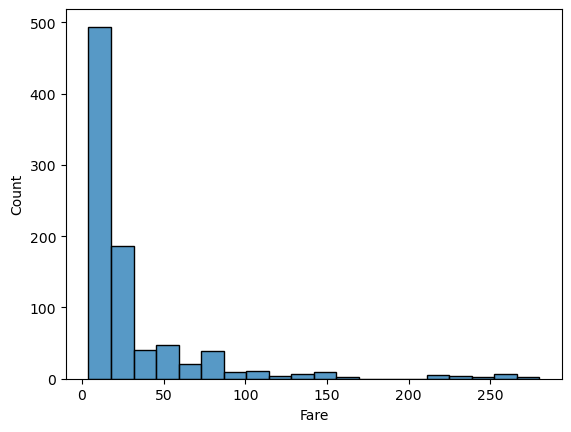

In [228]:
sns.histplot(df_train['Fare'], bins=20);

## Correlations

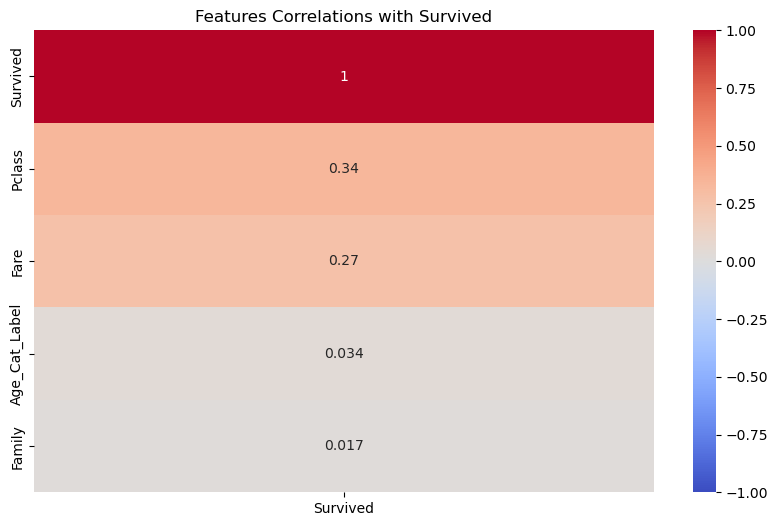

In [229]:
target_column = 'Survived'
corr_matrix = df_train.corr()
corr_with_target = corr_matrix[target_column].apply(np.abs).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title(f'Features Correlations with {target_column}')
plt.show()

__It is shocking for me to have such an almost ZERO correlation between age and survival__

In [230]:
df_train.corr()

,Survived,Pclass,Fare,Age_Cat_Label,Family
Survived,1.000000,-0.338481,0.267456,-0.033913,0.016639
Pclass,-0.338481,1.000000,-0.605384,-0.348179,0.065997
Fare,0.267456,-0.605384,1.000000,0.111554,0.251636
Age_Cat_Label,-0.033913,-0.348179,0.111554,1.000000,-0.266449
Family,0.016639,0.065997,0.251636,-0.266449,1.000000


**No multicollinearity issues**

## Inferences and Questions

### Gender and Survival Rate

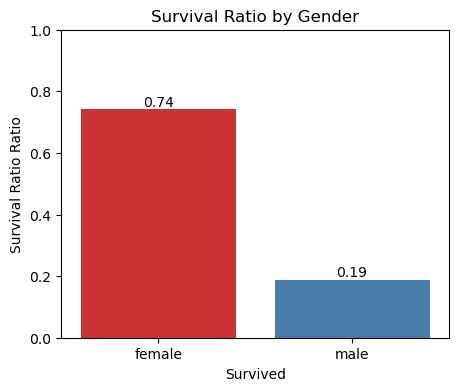

In [231]:
survival_ratio_gender = df_train.groupby('Sex')['Survived'].mean()

# Visualize the survival ratio with labels
plt.figure(figsize=(5, 4))
sns.barplot(x=survival_ratio_gender.index, y=survival_ratio_gender.values, palette='Set1')
plt.title('Survival Ratio by Gender')
plt.xlabel('Survived')
plt.ylabel('Survival Ratio Ratio')
plt.ylim(0,1)

for index, value in enumerate(survival_ratio_gender):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')
    
plt.show()

**Females seem to have almost 4 times higher possibility to survive than males**

### Survival Rates by Class

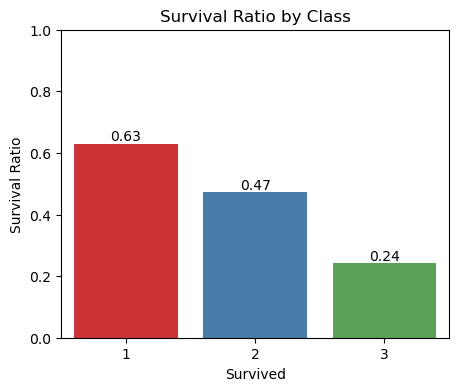

In [232]:
survival_ratio_pclass = df_train.groupby('Pclass')['Survived'].mean()

# Visualize the survival ratio with labels
plt.figure(figsize=(5, 4))
sns.barplot(x=survival_ratio_pclass.index, y=survival_ratio_pclass.values, palette='Set1')
plt.title('Survival Ratio by Class')
plt.xlabel('Survived')
plt.ylabel('Survival Ratio')
plt.ylim(0,1)

for index, value in enumerate(survival_ratio_pclass):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')
    
plt.show()

**As expected, higher class has a higher survival rate. 1st class travellers are 3 times high possible to survive than 3rd class passengers**

### Travel Alone vs. Family Travellers

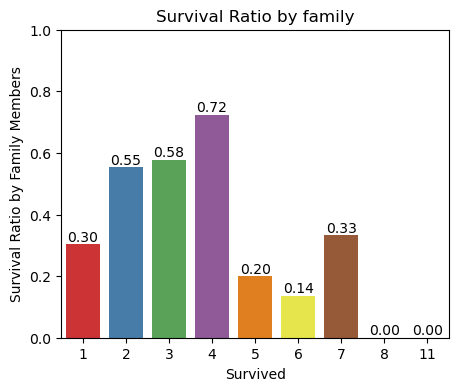

In [233]:
survival_ratio_family = df_train.groupby('Family')['Survived'].mean()

# Visualize the survival ratio with labels
plt.figure(figsize=(5, 4))
sns.barplot(x=survival_ratio_family.index, y=survival_ratio_family.values, palette='Set1')
plt.title('Survival Ratio by family')
plt.xlabel('Survived')
plt.ylabel('Survival Ratio by Family Members')
plt.ylim(0,1)

for index, value in enumerate(survival_ratio_family):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')
    
plt.show()

### Survival and Age

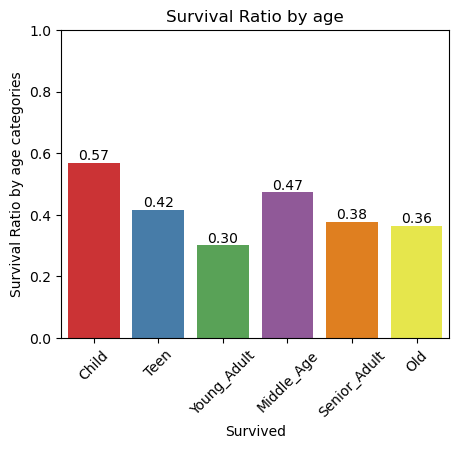

In [234]:
survival_ratio_age = df_train.groupby('Age_Category')['Survived'].mean()

# Visualize the survival ratio with labels
plt.figure(figsize=(5, 4))
sns.barplot(x=survival_ratio_age.index, y=survival_ratio_age.values, palette='Set1')
plt.title('Survival Ratio by age')
plt.xticks(rotation=45)
plt.xlabel('Survived')
plt.ylabel('Survival Ratio by age categories')
plt.ylim(0,1)

for index, value in enumerate(survival_ratio_age):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')
    
plt.show()

### Ticket Fares and Survival

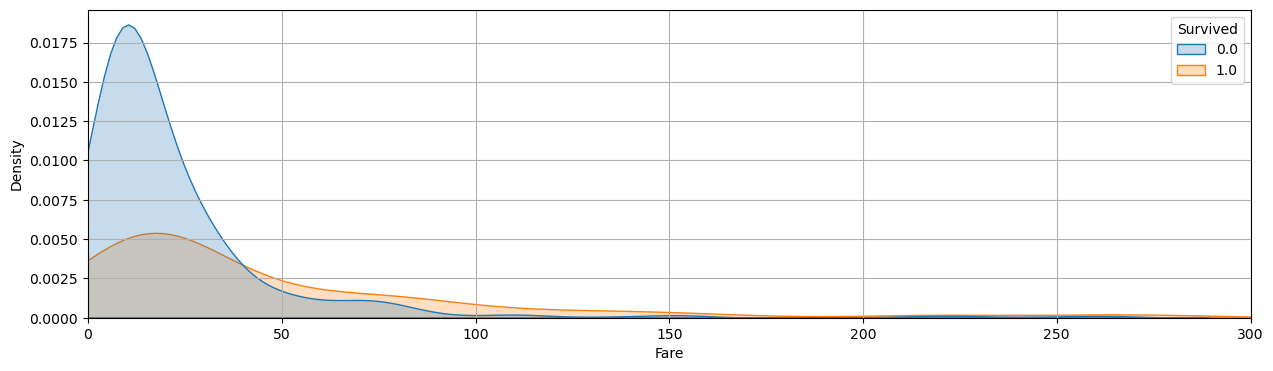

In [235]:
fig = plt.figure(figsize=(15,4))
sns.kdeplot(data=df_train, x='Fare', hue='Survived', common_norm=True, fill=True )  
plt.xlim(0, 300)
plt.grid()
plt.show()

**After 40 dollars, survival possibility surpass dying possibility**

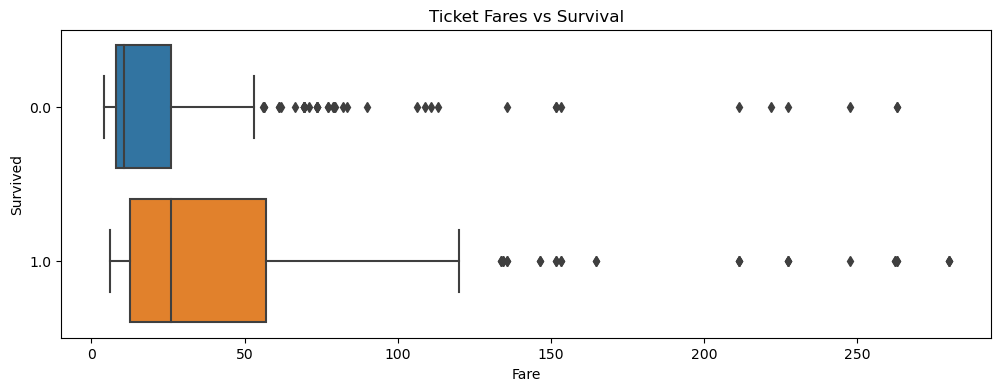

In [236]:
fig = plt.figure(figsize=(12,4))
sns.boxplot(data=df_train, x='Fare', y='Survived', orient='h')
plt.title('Ticket Fares vs Survival')
plt.show()

**75% of the passengers who died, has a ticket price of 25 or less**  
**On the other hand, half of the passengers who survived, paid more than this 25 amount**

### Titles and Survivals

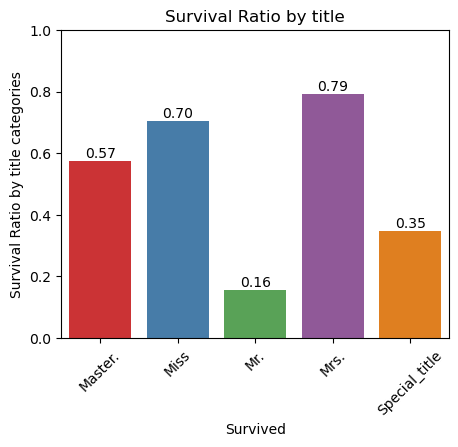

In [237]:
survival_ratio_title = df_train.groupby('Title')['Survived'].mean()

# Visualize the survival ratio with labels
plt.figure(figsize=(5, 4))
sns.barplot(x=survival_ratio_title.index, y=survival_ratio_title.values, palette='Set1')
plt.title('Survival Ratio by title')
plt.xticks(rotation=45)
plt.xlabel('Survived')
plt.ylabel('Survival Ratio by title categories')
plt.ylim(0,1)

for index, value in enumerate(survival_ratio_title):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')
    
plt.show()

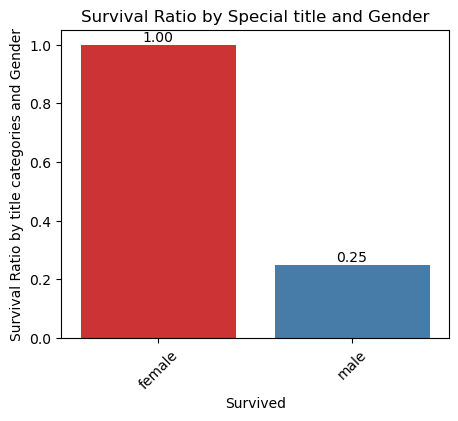

In [238]:
survival_ratio_special_title = df_train[df_train['Title']=='Special_title'].groupby('Sex')['Survived'].mean()

# Visualize the survival ratio with labels
plt.figure(figsize=(5, 4))
sns.barplot(x=survival_ratio_special_title.index, y=survival_ratio_special_title.values, palette='Set1')
plt.title('Survival Ratio by Special title and Gender')
plt.xticks(rotation=45)
plt.xlabel('Survived')
plt.ylabel('Survival Ratio by title categories and Gender')


for index, value in enumerate(survival_ratio_special_title):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')
    
plt.show()

### Genders, Age and Survival

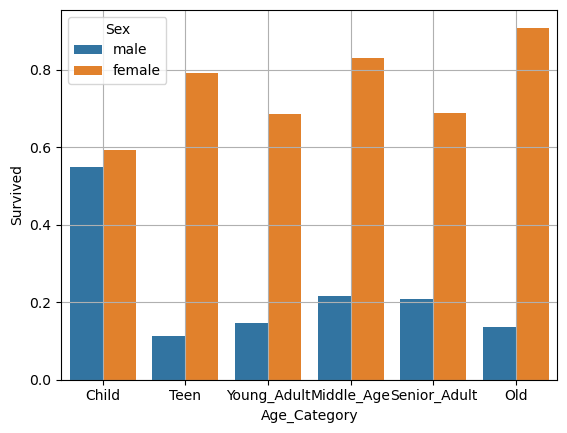

In [239]:
survival_ratio_gender_pclass = df_train.groupby(['Sex', 'Age_Category'])['Survived'].mean()

sns.barplot(data=df_train, x='Age_Category', y='Survived', hue='Sex', ci=None)
plt.grid()
plt.show()

* Child survival rates are almost identical no matter the genders  
* All other age groups: Females have far higher survival rates
* Males having special titles such as Colonel, Sir etc have almost 70% higher survival rates. (Normally its around %17 for a second and first class travelling male but its %25 for special titles)

### Gender, Classes and Survival

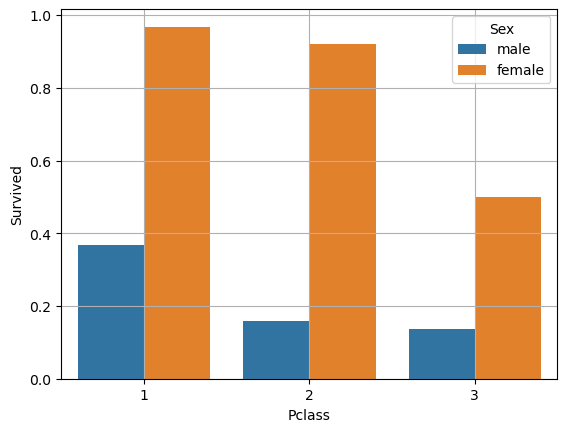

In [240]:
survival_ratio_gender_pclass = df_train.groupby(['Sex', 'Pclass'])['Survived'].mean()

sns.barplot(data=df_train, x='Pclass', y='Survived', hue='Sex', ci=None)
plt.grid()
plt.show()

**Female passengers traveling first and Second class have a survival rate of ove 90%**  
**whereas Males on second and Third Class is around 16%**

# 5. Model Building

## Data Encoding

In [241]:
# This was staying for better visualization and EDA
df_train.drop(columns=['Age_Category'], inplace=True)
df_test.drop(columns=['Age_Category'], inplace=True)

In [242]:
categorical_features = df_train.select_dtypes(include=['object', 'category']).columns
categorical_features

Index(['Sex', 'Embarked', 'Title'], dtype='object')

In [243]:
dummies_df_train = pd.get_dummies(df_train, categorical_features, drop_first=True)
dummies_df_test = pd.get_dummies(df_test, categorical_features, drop_first=True)

X = dummies_df_train.drop(columns=['Survived'])
y = df_train['Survived']
X_kaggle = dummies_df_test.copy()

print(X.shape)
print(y.shape)
print(X_kaggle.shape)

(891, 11)
(891,)
(418, 11)


In [244]:
X.sample(3)

,Pclass,Fare,Age_Cat_Label,Family,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr.,Title_Mrs.,Title_Special_title
26,3,7.225,2,1,1,0,0,0,1,0,0
150,2,12.525,5,1,1,0,1,0,0,0,1
417,2,13.000,1,3,0,0,1,1,0,0,0


In [245]:
X_kaggle.sample(3)

,Pclass,Fare,Age_Cat_Label,Family,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr.,Title_Mrs.,Title_Special_title
160,3,7.7333,2,1,0,1,0,1,0,0,0
311,3,7.2250,2,1,1,0,0,0,1,0,0
332,3,7.2250,2,1,1,0,0,0,1,0,0


In [246]:
y.sample(3)

579    1.0
134    0.0
199    0.0
Name: Survived, dtype: float64

## Train | Test Split

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scaling

In [248]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_kaggle_scaled = scaler.transform(X_kaggle)

## Model Runs

In [249]:
algorithms = [
    LogisticRegression(),
    RandomForestClassifier(random_state=42),
    XGBClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42)
]

In [250]:
model_scores = pd.DataFrame(columns=['Algorithm', 'Train_Accuracy', 'Test_Accuracy'])

for algorithm in algorithms:
    
    algorithm_score = {}
    algorithm_name = algorithm.__class__.__name__
    
    model = algorithm
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_train_pred = model.predict(X_train_scaled)
    
    accuracy_test = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    
    algorithm_score['Algorithm'] = algorithm_name
    algorithm_score['Train_Accuracy'] = accuracy_train
    algorithm_score['Test_Accuracy'] = accuracy_test
    
    model_scores = model_scores.append(algorithm_score, ignore_index=True)
    model_scores = model_scores.sort_values(by='Test_Accuracy', ascending=False)

model_scores    

,Algorithm,Train_Accuracy,Test_Accuracy
0,RandomForestClassifier,0.952247,0.854749
1,XGBClassifier,0.942416,0.837989
3,GradientBoostingClassifier,0.901685,0.832402
2,LogisticRegression,0.834270,0.810056


# 6. HyperParamtre Tuning

## XGBoost Params

## Logit Params

## RF Params

## GB Params

In [251]:
gb_classifier = GradientBoostingClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_model_gb = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model_gb.predict(X_test_scaled)

# Evaluate the performance of the best model
accuracy = accuracy_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy on the test set:", accuracy)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy on the test set: 0.8212290502793296


# 8. Dive Deep? Prediction Analysis

In [252]:
y_pred_proba_gb = best_model_gb.predict_proba(X_test_scaled)

In [253]:
y_pred_gb = best_model_gb.predict(X_test_scaled)

In [254]:
pred_comp_df = pd.DataFrame()

In [255]:
pred_comp_df[X_test.columns] = X_test
pred_comp_df['Survived'] = y_test
pred_comp_df['y_pred_gb'] = y_pred_gb
pred_comp_df['y_pred_proba_GB'] = y_pred_proba_gb[:,-1]

In [256]:
false_predictions = pred_comp_df['Survived'] != pred_comp_df['y_pred_gb']
print(f"Total False Predictions : {len(pred_comp_df[false_predictions])}")
pred_comp_df[false_predictions]

Total False Predictions : 32


,Pclass,Fare,Age_Cat_Label,Family,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr.,Title_Mrs.,Title_Special_title,Survived,y_pred_gb,y_pred_proba_GB
137,1,53.1000,3,2,1,0,1,0,1,0,0,0.0,1.0,0.582398
621,1,52.5542,4,2,1,0,1,0,1,0,0,1.0,0.0,0.495200
447,1,26.5500,3,1,1,0,1,0,1,0,0,1.0,0.0,0.333976
192,3,7.8542,1,2,0,0,1,1,0,0,0,1.0,0.0,0.467846
673,2,13.0000,3,1,1,0,1,0,1,0,0,1.0,0.0,0.125601
141,3,7.7500,2,1,0,0,1,1,0,0,0,1.0,0.0,0.467038
235,3,7.5500,2,1,0,0,1,1,0,0,0,0.0,1.0,0.727498
204,3,8.0500,1,1,1,0,1,0,1,0,0,1.0,0.0,0.110381
23,1,35.5000,2,1,1,0,1,0,1,0,0,1.0,0.0,0.277394
362,3,14.4542,4,2,0,0,0,0,0,1,0,0.0,1.0,0.561832


# 9. Submit Predictions

In [257]:
models_to_submit = [
    #best_model_logit,
    #best_model_xgb,
    best_model_gb,
    #best_model_rf
]

In [258]:
current_time = datetime.now()
formatted_time = current_time.strftime('%m_%d_%H_%M')

In [259]:
# Continue with fit X_train

## Fit and Predict with each model each model
for i, model in enumerate(models_to_submit):
    #Extract time now
    current_time = datetime.now()
    formatted_time = current_time.strftime('%m_%d_%H_%M')
    
    # Extract model name 'str'
    model_name = model.__class__.__name__
    
    # Final training the model with X_train_scaled, y_train
    model.fit(X_train_scaled, y_train)
    
    # Real predictions to df : X_kaggle_scaled (scaled with X_train stats)
    y_pred = model.predict(X_kaggle_scaled)
    submit_df = pd.DataFrame({'PassengerId': df_test2['PassengerId'], 'Survived': y_pred})
    
    # save the file as csv
    filepath = 'submissions/' + 'partial' + formatted_time + str(i) + '_' + model_name + '.csv'
    submit_df.to_csv(filepath, index=False)